# Large Movie Review Dataset Sentiment Analysis

The IMDB Movie review dataset is for binary sentiment classification containing substantially more data than previous benchmark datasets. It has  

*   50,000 reviews with 25,000 positive reviews & 25000, negative reviews
*   A total of 108848 distinct words in the corpus
*   An average of 231 words per review
*   Biggest review with 2470 words and smallest review with 4 words



In [0]:
# Load all the required py modules
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import nltk

from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

import seaborn as sns

%tensorflow_version 1.x

In [0]:
# Download the punkt package for tokenizing
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Naive Bayes Classifier using SKLearn

We will establish a benchmark accuracy using Naive bayes which our neural network will try to beat . Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable.



In [0]:
# Read in aggregated dataset
df = pd.read_csv('IMDB Dataset.csv')

In [0]:
#tokenize the reviews
tokeniser = CountVectorizer( tokenizer=nltk.word_tokenize)

# Encode 'Positive' & 'Negative' classes to 1 & 0
encoder = LabelEncoder()
oneHotEncoder = OneHotEncoder()

In [0]:
# Use 75 % of the reviews for training and test on 25%
X_train,X_test,Y_train,Y_test = train_test_split(df.review, df.sentiment ,random_state = 32)

In [0]:
# reviews to tokenized form
X_train_vec = tokeniser.fit_transform(X_train)

In [0]:
# 1,0 encoded classes
Y_train_enc = encoder.fit_transform(Y_train)

In [0]:
#Train
clf = MultinomialNB()
clf.fit(X_train_vec, Y_train_enc)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [0]:
#Test
X_test_vec = tokeniser.transform(X_test)
Y_test_enc = encoder.transform(Y_test)


In [0]:
y_predicted = clf.predict(X_test_vec)

In [0]:
accuracy_score(Y_test_enc,y_predicted)

0.8408

In [0]:
print(classification_report(Y_test_enc,y_predicted))

              precision    recall  f1-score   support

           0       0.82      0.87      0.84      6169
           1       0.87      0.81      0.84      6331

    accuracy                           0.84     12500
   macro avg       0.84      0.84      0.84     12500
weighted avg       0.84      0.84      0.84     12500



## LSTM Implementation using Keras & Tensorflow

Our choice of Neural Networks is Long Short-Term Memory networks (LSTM). LSTM’s are a special case of Recurrent Neural Networks (RNN) which has the capability of learning long-term dependencies. 

![LSTM architecture](https://i.stack.imgur.com/voZql.jpg)

### Justification for using LSTM

* LSTM networks don’t suffer from the vanishing gradient problem unlike RNNs
* They can hold on to long term dependencies. The presence of many words in the review might have alter its meaning. LSTM can handle this scenario well.
* Contains memory cell that can hold information for long period of time.
* Gates at input, forget and output layers can be controlled to manage the information in a single LSTM cell.
* Like RNN, LSTM can also handle sequences of data points.

In [0]:
from tensorflow.python.keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [0]:
from keras.models import Model
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Embedding, Flatten, LSTM
from keras import optimizers

In [0]:
df = pd.read_csv('IMDB Dataset.csv')

In [0]:
X_train,X_test,Y_train,Y_test = train_test_split(df.review, df.sentiment ,random_state = 32)

## Word embeddings

The reviews are not always of the same length. The input to a neural network needs to equal length vectors. So, 

* Keras’s tokeniser was used to tokenize the input reviews
* All the reviews were cut off to a maximum number of 500 words
* Reviews with less than 500 words were padded to get a uniform length
* Words were converted to the word index in the vocabulary
* A word embedded layer was utilized to reduce the 500-dimension word vectors to 100-dimension word vectors


In [0]:
# Tokenise the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(X_train))

In [0]:
Y_train_enc = encoder.fit_transform(Y_train)

In [0]:
Y_test_enc = encoder.transform(Y_test)

In [0]:
# convert words to word in in vocabulary 
list_tokenized_train = tokenizer.texts_to_sequences(X_train)
list_tokenized_test = tokenizer.texts_to_sequences(X_test)

#Total unique words 
print(len(tokenizer.word_index))

108848


In [0]:
vocab_size = len(tokenizer.word_index) + 1
maxlen = 500

# This makes all reviews to be of size 500 Vector
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)



In [0]:
X_t.shape

(37500, 500)

In [0]:
model = Sequential()

# Find embeddings for input to 100 dimensions
model.add(Embedding(vocab_size, 100, input_length=maxlen))
model.add(Dropout(0.5))
# LSTM for sentiment classification
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 100)          10884900  
_________________________________________________________________
dropout_3 (Dropout)          (None, 500, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 10,927,270
Trainable params: 10,927,270
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit([X_t], batch_size=32, y=to_categorical(Y_train_enc), verbose=1, validation_split=0.25, 
          shuffle=True, epochs=3)




Train on 28125 samples, validate on 9375 samples
Epoch 1/3





28125/28125 [==============================] - 557s 20ms/step - loss: 0.6340 - acc: 0.6472 - val_loss: 0.5518 - val_acc: 0.7333
Epoch 2/3
28125/28125 [==============================] - 558s 20ms/step - loss: 0.4141 - acc: 0.8180 - val_loss: 0.3299 - val_acc: 0.8580
Epoch 3/3
28125/28125 [==============================] - 556s 20ms/step - loss: 0.2299 - acc: 0.9158 - val_loss: 0.3110 - val_acc: 0.8843


In [0]:

predicted = model.predict(X_te)
Y_predicted = np.argmax(predicted, axis=1)
print (accuracy_score(Y_test_enc,Y_predicted))


0.88136


In [0]:
print (classification_report(Y_test_enc,Y_predicted))


              precision    recall  f1-score   support

           0       0.85      0.92      0.88      6169
           1       0.91      0.85      0.88      6331

    accuracy                           0.88     12500
   macro avg       0.88      0.88      0.88     12500
weighted avg       0.88      0.88      0.88     12500



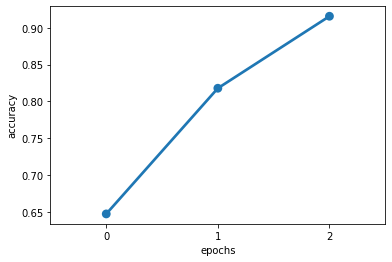

In [0]:
# Plot Accuracy vs Epoch to show learning rate
df_result = pd.DataFrame({'epochs':history.epoch, 'accuracy': history.history['acc'], 'validation_accuracy': history.history['val_acc']})
g = sns.pointplot(x="epochs", y="accuracy", data=df_result, fit_reg=False)

In [0]:
df_result.to_csv('EpochHistory.csv',index=False)

Showing Incorrectly classified Reviews



*   Find out all indices where our prediction & true label did not match (Logical XNOR )
*   Sample the original Dataframe with these indices and dislay full reviews




In [0]:
incorrect_index = (~np.logical_xor(Y_test_enc,Y_predicted)).nonzero()

In [0]:
pd.set_option('display.max_colwidth', -1)
df.iloc[incorrect_index].sample(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,review,sentiment
5106,"You'd have more excitement cutting off your testicles than watching this, clearly a trick to get you to rent ""Descent"" instead of ""The Descent"", which is a much better movie.<br /><br />This is a total rip off of ""The Core"" and much, much worse as regards special effects, I could do better with a box of cornflakes and a roll of tinfoil, I mean come on!....that ""Mole"" thing, bore more resemblance to a vibrating dildo than a subterranean vehicle .<br /><br />Don't watch it - if you do you'll find the room your in has a funny smell for days after and you'll have this nagging feeling in the back of your head that you should go kill yourself or something.",negative
1987,"Gary Busey is superb in this musical biography. Great singing and excellent soundtrack. The Buddy Holly Story is a much better movie than La Bamba. From reading other comments, there may be some historical inaccuracies. Regardless, it is a fun toe-tapping film, and a good introduction to Buddy Holly's music.",positive
11798,"Ghost Train is a fine and entertaining film, typical of the better British comedy chillers of the 1930s and 40s. The antics of comedian Arthur Askey are not as funny as they once apparently were, but this can be overcome by viewing him as a period piece or a curiosity.<br /><br />For a low-budget wartime production, Ghost Train is atmospheric, effective, and it provides some genuine suspense. Great fun for a dark (and, yes, stormy) night. Lighten up, take off the critic's hat, and enjoy.",positive
8697,Witty and disgusting. Brash and intelligent. BASEketball redefines comedy/sports with a pot spoof of an easy target. Makes other so called comedies like dead boring. One of the best of all time! Trey Parker and Matt Stone play their roles as losers with apt perfection.,positive
1213,"being a high school student,i have to take a health class. this year, the topic is drugs. we learn about the harm they can cause a person. from what we talk about, i still believe and know that drugs can really mess a person up. anyway, my teacher wanted us to watch this. naturally, we groan and start to sleep, but like the rest of my class, i actually did enjoy this movie. it was totally real, and not sugar coated at all. the characters were amazing and believable. even the plot was outstandingly realistic and believable. what i liked about this movie mainly was how it got the point of the effect's drugs can take on an abuser, and the consequences the person has to deal with. everyone reassures themselves that nothing bad will happen to them. well lets get serious. anything can happen in a small town, even to your best friend, like Sam and Chris. this movie shows it. a person can really learn a lot from watching this. it was pretty effective.",positive


## References

#### Aggregated Dataset source

* https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
* https://ai.stanford.edu/~amaas/data/sentiment/

#### Scikit-learn Naïve Bayes Classifier Tutorial

* https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
* https://scikit-learn.org/stable/modules/naive_bayes.html

#### Word Embedding Tutorials

* https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
* https://colab.research.google.com/github/pasumarthi/Backprop/blob/master/ADR_tweet_classifier_keras.ipynb



#### LSTM Tutorials

* https://colah.github.io/posts/2015-08-Understanding-LSTMs/
* https://medium.com/@saurabh.rathor092/simple-rnn-vs-gru-vs-lstm-difference-lies-in-more-flexible-control-5f33e07b1e57

#### Keras - LSTM sentiment analysis sources

* https://www.kaggle.com/eriche523/bidirectional-lstm-in-keras
* https://www.kaggle.com/khaledmgamal/bag-of-words-rnn-lstm-sentiment/notebook